In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import os
import time


In [3]:
DATA_PATH = "/kaggle/input/utkface-new/UTKFace/"
SAVE_PATH = "/kaggle/working/"

def Load_data():
    filenames=[]
    age=[]
    gender=[]
    race=[]
    for filename in os.listdir(DATA_PATH):
        args=filename.split('_')
        if len(args)==4:
            age.append(int(args[0]))
            gender.append(int(args[1]))
            race.append(int(args[2]))
            filenames.append(filename)
    d = {'age': age, 'gender': gender, 'race': race,  'filename': filenames} 
    return pd.DataFrame(data=d)
    
            

data=Load_data()

In [4]:
data.head()

,age,gender,race,filename
0,26,0,2,26_0_2_20170104023102422.jpg.chip.jpg
1,22,1,1,22_1_1_20170112233644761.jpg.chip.jpg
2,21,1,3,21_1_3_20170105003215901.jpg.chip.jpg
3,28,0,0,28_0_0_20170117180555824.jpg.chip.jpg
4,17,1,4,17_1_4_20170103222931966.jpg.chip.jpg


<Axes: xlabel='age'>

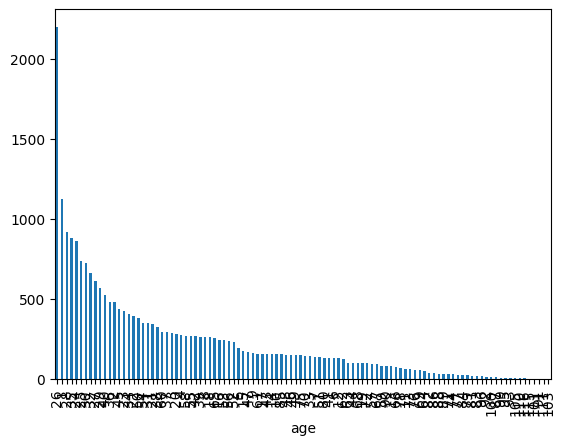

In [5]:
data['age'].value_counts().plot.bar()

<Axes: xlabel='gender'>

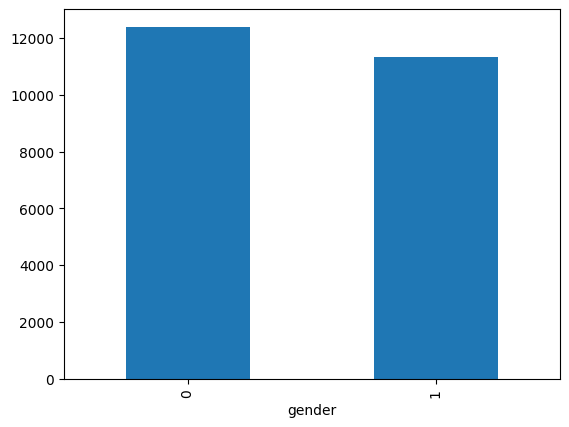

In [6]:
data['gender'].value_counts().plot.bar()

<Axes: xlabel='race'>

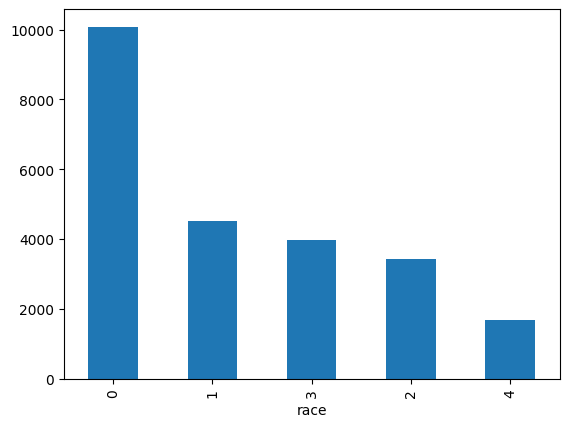

In [7]:
data['race'].value_counts().plot.bar()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       23705 non-null  int64 
 1   gender    23705 non-null  int64 
 2   race      23705 non-null  int64 
 3   filename  23705 non-null  object
dtypes: int64(3), object(1)
memory usage: 740.9+ KB


In [9]:
data.isna().sum()

age         0
gender      0
race        0
filename    0
dtype: int64

In [4]:

class CustomDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df=df
        if transform:
            self.transform=transform
        else:
            self.transform=transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image=Image.open(DATA_PATH+self.df['filename'].iloc[idx]).convert('RGB')
        
        image=self.transform(image)
        age=self.df['age'].iloc[idx]
        gender=self.df['gender'].iloc[idx]
        race=self.df['race'].iloc[idx]
        
        res={'image':image,'age':age,'gender':gender,'race':race}
        return res

In [5]:
transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset=CustomDataset(data,transform=transform)

In [6]:
train_size=int(0.95*len(dataset))

test_size=len(dataset)-train_size

train,test=random_split(dataset,[train_size,test_size])

train_loader=DataLoader(train,batch_size=32,shuffle=True)

test_loader=DataLoader(test,batch_size=32,shuffle=False)


In [17]:

class Hydranet(nn.Module):
    def __init__(self):
        super(Hydranet,self).__init__()
        self.backbone=models.resnet34(pretrained=True)
        self.model_in_features=self.backbone.fc.in_features
        self.backbone.fc=nn.Identity()
        self.backbone.fc1=nn.Sequential(nn.Linear(self.model_in_features,self.model_in_features),nn.ELU(),nn.Linear(self.model_in_features,1))
        self.backbone.fc2=nn.Sequential(nn.Linear(self.model_in_features,self.model_in_features),nn.ELU(),nn.Linear(self.model_in_features,1),nn.Sigmoid())
        self.backbone.fc3=nn.Sequential(nn.Linear(self.model_in_features,self.model_in_features),nn.ELU(),nn.Linear(self.model_in_features,5))
    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self,x):
        age_head = self.backbone.fc1(self.backbone(x))
        gender_head = self.backbone.fc2(self.backbone(x))
        race_head = self.backbone.fc3(self.backbone(x))
        return age_head, gender_head, race_head
    

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Hydranet().to(device=device)
race_loss = nn.CrossEntropyLoss() 
gender_loss = nn.BCELoss() 
age_loss = nn.L1Loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)  

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 35.0MB/s]


In [19]:
def accuracy(pred,true):
    predicted_labels = torch.argmax(pred, dim=1)
    correct_predictions = (predicted_labels == true).sum().item()
    acc = correct_predictions /len(true)
    return acc

def binary_accuracy(pred,true):
    correct_predictions=(pred==true).sum().item()
    acc=correct_predictions/len(true)
    return acc

In [20]:
class MultiTaskLoss(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLoss, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, losses):
        weighted_losses = torch.exp(-self.log_vars) * losses
        return torch.sum(weighted_losses)

In [21]:
multi_task_loss = MultiTaskLoss(task_num=3).to(device)
n_epochs=10
for epoch in range(n_epochs):
    train_epoch_loss=[]
    model.train()
    epoch_loss=0
    for i, data in enumerate(train_loader):
        inputs = data["image"].to(device=device)
        age_label = data["age"].to(device=device)
        gender_label = data["gender"].to(device=device)
        race_label = data["race"].to(device=device)
        optimizer.zero_grad()
        age_pred, gender_pred, race_pred = model(inputs)
        loss_1 = race_loss(race_pred, race_label)
        loss_2 = gender_loss(gender_pred, gender_label.unsqueeze(1).float())
        loss_3 = age_loss(age_pred, age_label.unsqueeze(1).float())
        losses = torch.stack([loss_1, loss_2, loss_3])
        loss = multi_task_loss(losses)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_epoch_loss.append(loss)
    else:
        
        test_epoch_loss=[]
        with torch.no_grad():
            model.eval()
            for i, data in enumerate(test_loader):
                inputs = data["image"].to(device=device)
                age_label = data["age"].to(device=device)
                gender_label = data["gender"].to(device=device)
                race_label = data["race"].to(device=device)
        
                age_pred, gender_pred, race_pred = model(inputs)
                loss_1 = race_loss(race_pred, race_label)
                loss_2 = gender_loss(gender_pred, gender_label.unsqueeze(1).float())
                loss_3 = age_loss(age_pred, age_label.unsqueeze(1).float())
                test_losses=torch.stack([loss_1,loss_2,loss_3])
                test_loss= multi_task_loss(test_losses)
                test_epoch_loss.append(test_loss)
                
                
    print(f"epoch{epoch+1}")             
    print(f'training loss: {sum(train_epoch_loss)/len(train_epoch_loss)}, test loss: {sum(test_epoch_loss)/len(test_epoch_loss)}')    
      
    
                  

epoch1
training loss: 8.852721214294434, test loss: 7.500938892364502
epoch2
training loss: 6.838399410247803, test loss: 6.539812088012695
epoch3
training loss: 6.1167778968811035, test loss: 5.97177791595459
epoch4
training loss: 5.553042888641357, test loss: 5.713779926300049
epoch5
training loss: 5.097029209136963, test loss: 5.962953090667725
epoch6
training loss: 4.697836399078369, test loss: 5.68253755569458
epoch7
training loss: 4.345372676849365, test loss: 5.694497108459473
epoch8
training loss: 4.008371829986572, test loss: 5.4324846267700195
epoch9
training loss: 3.761439323425293, test loss: 5.532361030578613
epoch10
training loss: 3.4888699054718018, test loss: 5.499938011169434


In [22]:
r_test_loss=[]
a_test_loss=[]
g_test_loss=[]
with torch.no_grad():
            model.eval()
            for i, data in enumerate(test_loader):
                inputs = data["image"].to(device=device)
                age_label = data["age"].to(device=device)
                gender_label = data["gender"].to(device=device)
                race_label = data["race"].to(device=device)
    
                
        
                age_pred, gender_pred, race_pred = model(inputs)
                gender_pred=torch.round(gender_pred).float()
    
                loss_1 = accuracy(race_pred, race_label)
                loss_2 = binary_accuracy(gender_pred, gender_label.unsqueeze(1).float())
                loss_3 = age_loss(age_pred, age_label.unsqueeze(1).float())
                r_test_loss.append(loss_1)
                a_test_loss.append(loss_3)
                g_test_loss.append(loss_2)
            print(f"race_test_accuracy: {sum(r_test_loss)/len(r_test_loss)}, gender_accuracy:{sum(g_test_loss)/len(g_test_loss)},age_mae:{sum(a_test_loss)/len(a_test_loss)}") 
                

race_test_accuracy: 0.8256578947368421, gender_accuracy:0.9276315789473685,age_mae:4.733038902282715


**Achieved gender recognition accuracy equal to 92.76 %, race prediction accuracy equal to 82.56 % , and age Mean Absolute Error equal to 4.73 years.**

In [24]:
torch.save(model, 'model.pth')

# **Inference Pipeline**

In [68]:

def Inference(image_path):
    
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()])
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.title('Input Image')
    plt.show()
    image = transform(image).unsqueeze(0).to(device)
    
    saved_model_path = 'model.pth'  
    model = torch.load(saved_model_path)
    model.eval() 
    with torch.no_grad():
        age_pred,gender_pred,race_pred = model(image)
    age_pred=torch.round(age_pred).float()
    gender_pred=torch.round(gender_pred).float()
    race_probabilities = F.softmax(race_pred, dim=1).cpu().numpy()
    race_pred=np.argmax(race_probabilities,axis=1)
    gender_map={0.0:'Male',1.0:'Female'}
    race_map={0.0:'White',1.0:'Black',2.0:'Asian',3.0:'Indian',4.0:'Others'}
    print(f"Age:{age_pred.item()},\nGender:{gender_map[gender_pred.item()]}, \nRace:{race_map[race_pred[0]]}")
    
    
    

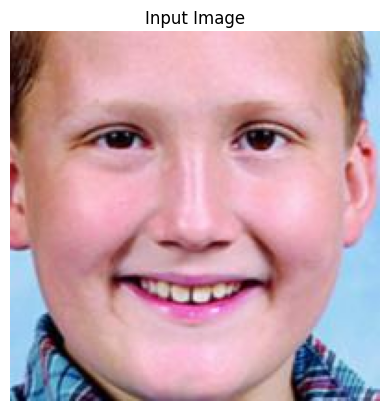

Age:12.0,
Gender:Male, 
Race:White


In [66]:
 Inference('/kaggle/input/utkface-new/UTKFace/10_0_0_20170103200329407.jpg.chip.jpg')
    

> Actual:   10, Male, White

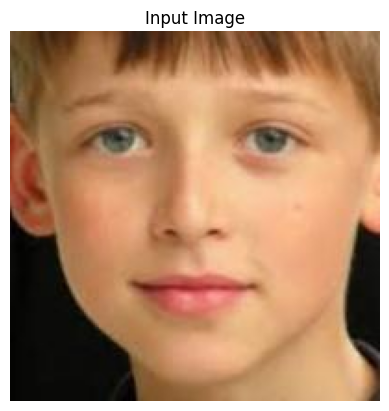

Age:9.0,
Gender:Male, 
Race:White


In [69]:
Inference('/kaggle/input/utkface-new/UTKFace/10_0_0_20161220222308131.jpg.chip.jpg')

Actual: 10, Male, White

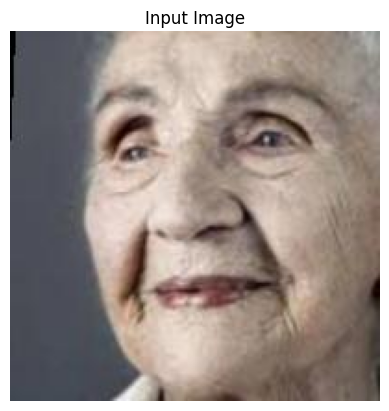

Age:90.0,
Gender:Female, 
Race:White


In [70]:
Inference('/kaggle/input/utkface-new/UTKFace/100_1_0_20170117195420803.jpg.chip.jpg')

Actual: 100, Female, White

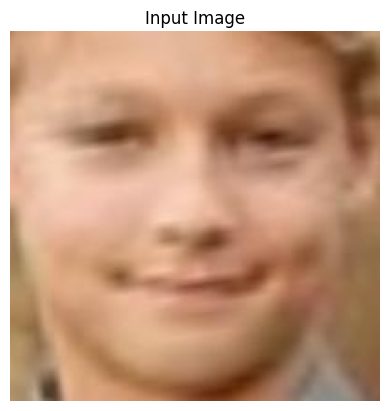

Age:13.0,
Gender:Male, 
Race:White


In [72]:
Inference('/kaggle/input/utkface-new/UTKFace/12_0_0_20170110225540554.jpg.chip.jpg')

Actual : 12, Male, White

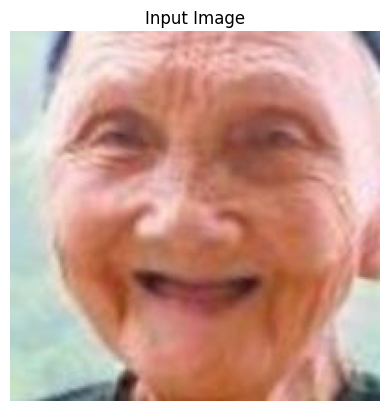

Age:93.0,
Gender:Female, 
Race:Asian


In [77]:
Inference('/kaggle/input/utkface-new/UTKFace/101_1_2_20170105174739309.jpg.chip.jpg')

Actual: 100, Female, Asian

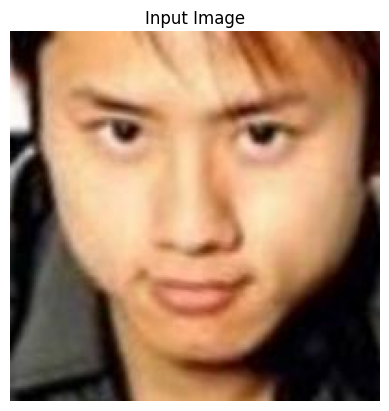

Age:25.0,
Gender:Male, 
Race:Asian


In [79]:
Inference('/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg')

Actual: 26 Male Asian

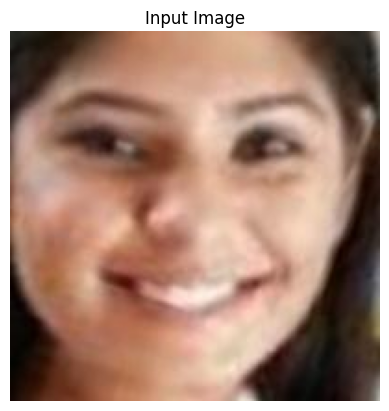

Age:20.0,
Gender:Female, 
Race:Indian


In [82]:
Inference('/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg')

Actual: 21, Female, Indian